In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import joblib

In [ ]:
data = pd.read_csv('imdb_movies.csv')
data.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [ ]:
data.isnull().sum()

,0
names,0
date_x,0
score,0
genre,85
overview,0
crew,56
orig_title,0
status,0
orig_lang,0
budget_x,0


In [ ]:
#data preprocessing
#drop crew rows with missing values
data.dropna(subset=['crew'], inplace=True)
#filling genre feature with unknown
data['genre'].fillna('Unknown', inplace=True)

# data.isnull().sum()

In [ ]:
#selecting useful feature for the model
data_clean = data[['date_x', 'score', 'genre', 'budget_x', 'revenue']]
data_clean.head()

,date_x,score,genre,budget_x,revenue
0,03/02/2023,73.0,"Drama, Action",75000000.0,2.716167e+08
1,12/15/2022,78.0,"Science Fiction, Adventure, Action",460000000.0,2.316795e+09
2,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy",100000000.0,7.244590e+08
3,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy",12300000.0,3.420000e+07
4,03/17/2023,61.0,Action,77000000.0,3.409420e+08


In [ ]:
#check for duplicates
data_clean.duplicated().sum()
data = data_clean.drop_duplicates()

In [ ]:
#ROI feature
data['ROI'] = (data['revenue'] - data['budget_x']) / data['budget_x']

#convert date to datetime format
data['date_x'] = pd.to_datetime(data['date_x'])

#extract year, month, nad day of the week
data['year'] = data['date_x'].dt.year
data['month'] = data['date_x'].dt.month
data['day_of_week'] = data['date_x'].dt.dayofweek


In [ ]:
#holiday or seasonal release
def holiday_season(month):
    if month in [6, 7, 11, 12]:
        return 1
    else:
        return 0

data['holiday_season'] = data['month'].apply(holiday_season)

In [ ]:
#calculate the day of the year the movie was released
data['day_of_year'] = data['date_x'].dt.dayofyear

#trend over time through a decade-based
data['decade'] = (data['year'] // 10) * 10
# data.head()

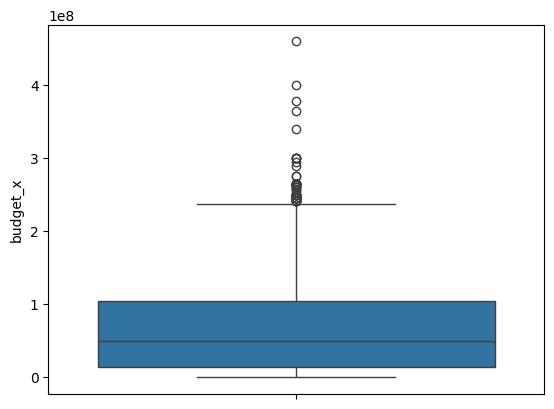

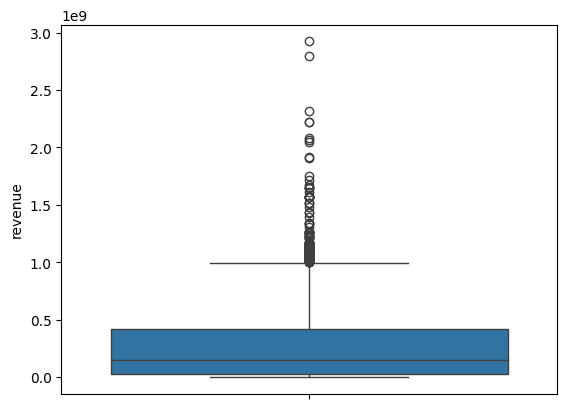

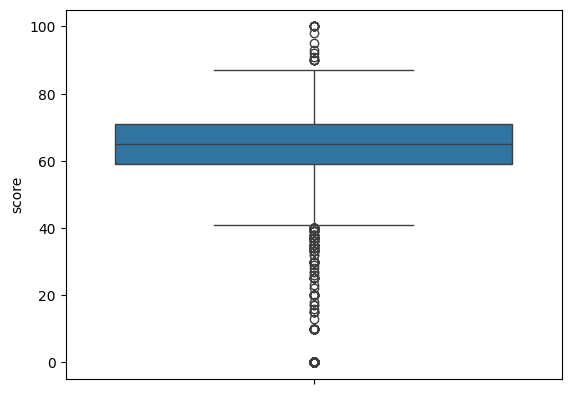

In [ ]:
#handling outliers

sns.boxplot(data['budget_x'])
plt.show()

sns.boxplot(data['revenue'])
plt.show()

sns.boxplot(data['score'])
plt.show()



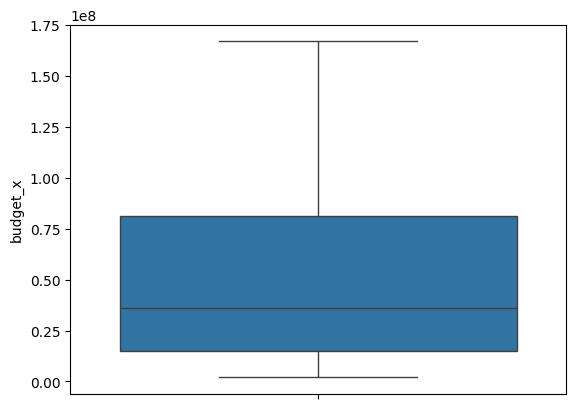

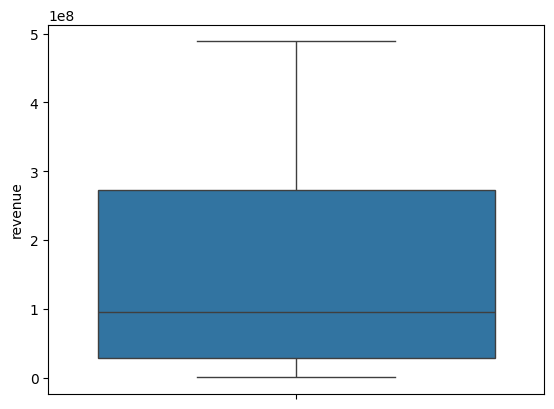

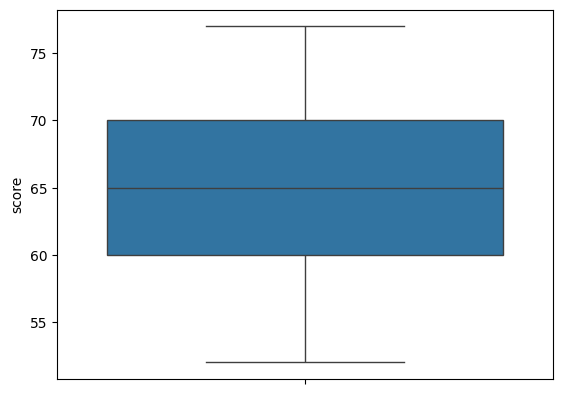

In [ ]:
#removing ouliers
data = data[(data['budget_x'] < data['budget_x'].quantile(0.95)) & (data['budget_x'] > data['budget_x'].quantile(0.05))]
data = data[(data['revenue'] < data['revenue'].quantile(0.80)) & (data['revenue'] > data['revenue'].quantile(0.05))]
data = data[(data['score'] < data['score'].quantile(0.95)) & (data['score'] > data['score'].quantile(0.05))]
sns.boxplot(data['budget_x'])
plt.show()

sns.boxplot(data['revenue'])
plt.show()

sns.boxplot(data['score'])
plt.show()

In [ ]:
# encoding categorical
#one-hot encoding
data = pd.get_dummies(data, columns=['genre'])
# data.head(10)

In [ ]:
cat_col =  data.select_dtypes(include=['object']).columns
num_col = data.select_dtypes(include=['int', 'float']).columns
#feature scaling
scaler = StandardScaler()
data[['budget_x', 'revenue', 'score']] = scaler.fit_transform(data[['budget_x', 'revenue', 'score']])
data.head()

,date_x,score,budget_x,revenue,ROI,year,month,day_of_week,holiday_season,day_of_year,...,"genre_Western, Drama, Action, Romance","genre_Western, Drama, Adventure","genre_Western, Drama, Crime","genre_Western, Drama, History","genre_Western, Drama, Mystery","genre_Western, Horror","genre_Western, Horror, Mystery","genre_Western, Mystery","genre_Western, Mystery, Thriller, Drama","genre_Western, Thriller"
0,2023-03-02,0.713066,0.187905,0.069607,2.621556,2023,3,3,0,61,...,False,False,False,False,False,False,False,False,False,False
1,2022-12-15,1.097611,6.967084,7.426159,4.036511,2022,12,3,1,349,...,False,False,False,False,False,False,False,False,False,False
2,2023-04-05,0.943793,0.628112,1.698491,6.244590,2023,4,2,0,95,...,False,False,False,False,False,False,False,False,False,False
3,2023-01-05,0.482340,-0.916132,-0.784386,1.780488,2023,1,3,0,5,...,False,False,False,False,False,False,False,False,False,False
4,2023-03-17,-0.209840,0.223122,0.318972,3.427818,2023,3,4,0,76,...,False,False,False,False,False,False,False,False,False,False


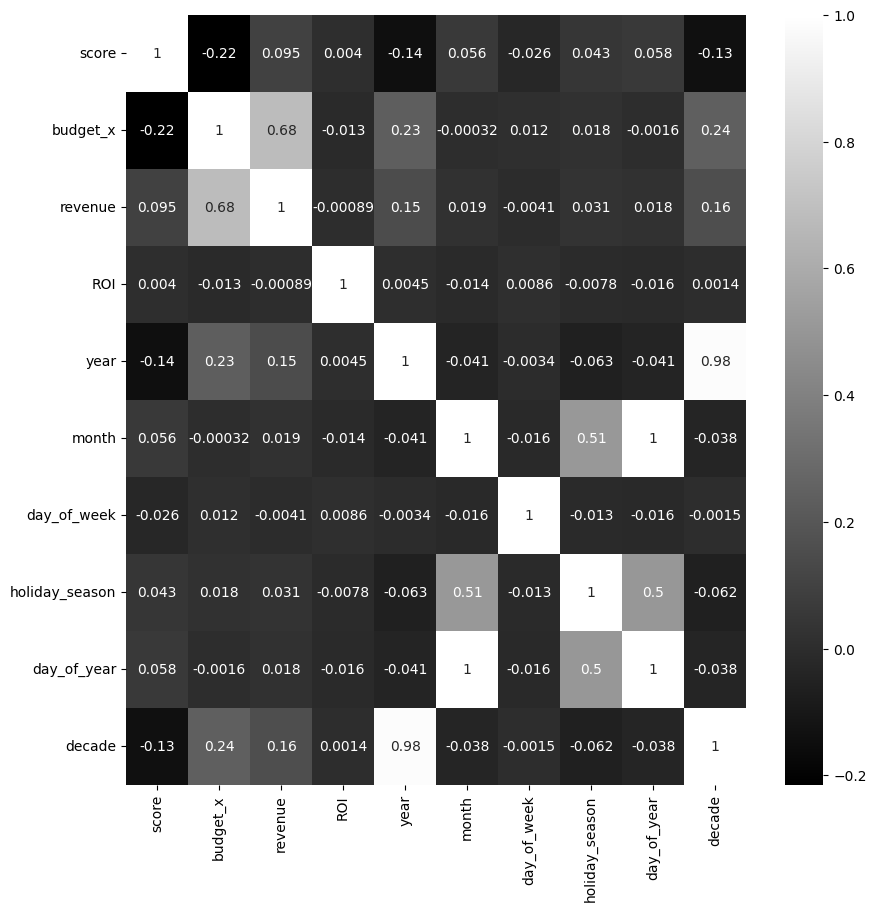

In [ ]:
#check correlation matrix

corr = data[num_col].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap = 'gray')
plt.show()

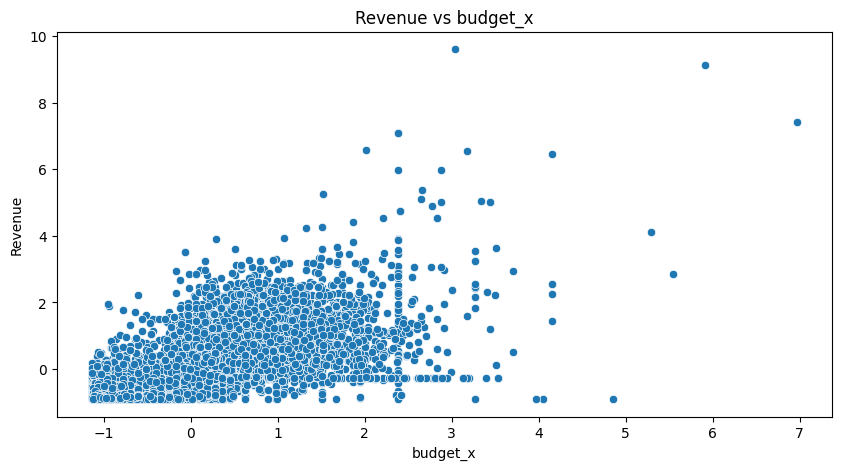

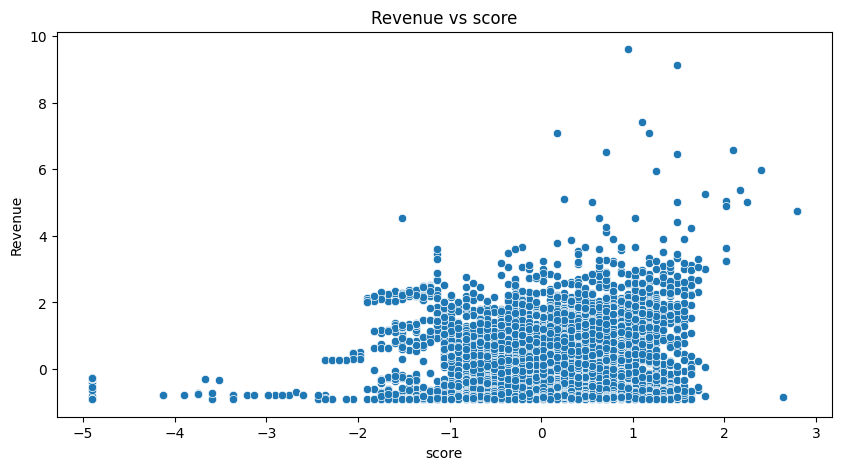

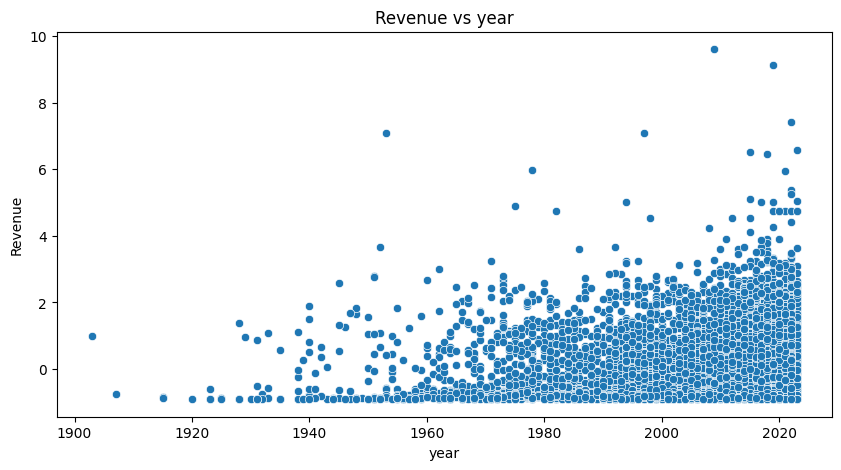

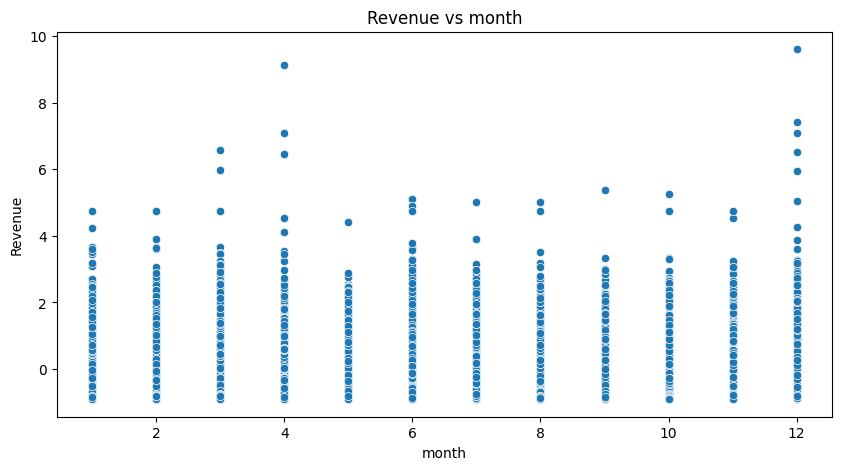

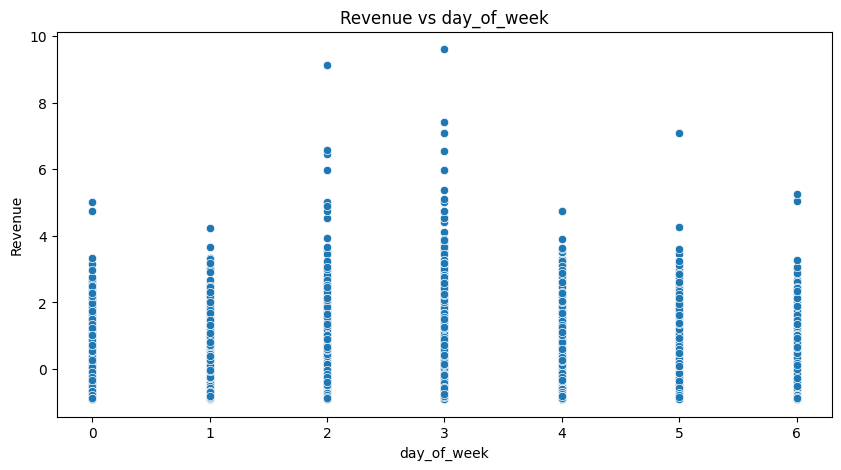

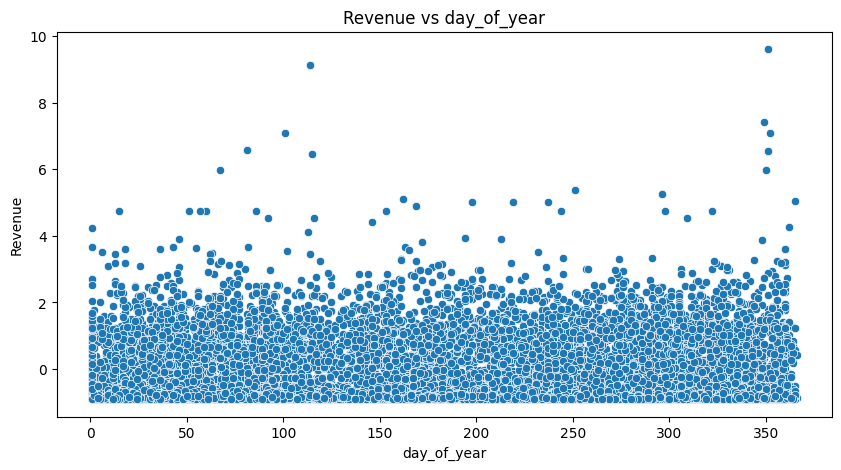

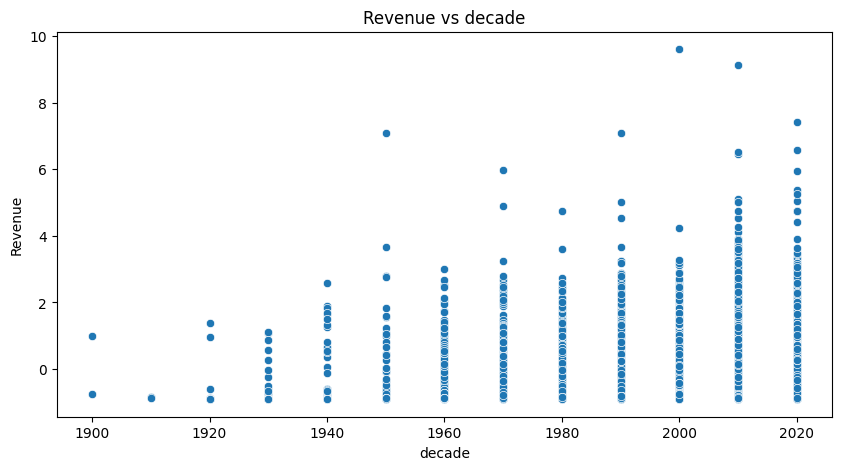

In [ ]:

numerical_features = ['budget_x', 'score', 'year', 'month', 'day_of_week', 'day_of_year', 'decade']


for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=feature, y='revenue', data=data)
    plt.title(f'Revenue vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Revenue')
    plt.show()



In [ ]:
#split the data into training and testing set
X = data.drop(['revenue', 'date_x'], axis=1)
y = data['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4796, 1643) (1199, 1643) (4796,) (1199,)


In [ ]:
#regression model
#linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

-5.8018911655876996e+22
5.750864875225161e+22


In [ ]:
#randomforest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.9984028274348984
0.001583125801944622


In [ ]:
#decisiontree regressor
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.9950566113213457
0.004899912719024442


In [ ]:
#support vector regressor
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.9459522501385983
0.053572412406913246


In [ ]:
#compare the models

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")

    print("MSE:", mse)
    print("R2 Score:", r2)


models = [lr, rf, dt, svr]
for model in models:
    evaluate_model(model, X_train, X_test, y_train, y_test)

Model: LinearRegression
MSE: 5.750864875225161e+22
R2 Score: -5.8018911655876996e+22
Model: RandomForestRegressor
MSE: 0.0017098129455352684
R2 Score: 0.9982750162212566
Model: DecisionTreeRegressor
MSE: 0.00506000171556043
R2 Score: 0.994895101886702
Model: SVR
MSE: 0.053572412406913246
R2 Score: 0.9459522501385983


In [ ]:
'''#hyper parameter tuning
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']

              }

rf_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
rf_search.fit(X_train, y_train)
best_model = rf_search.best_estimator_
y_pred = best_model.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))'''